# Batch forecasting on Ray Tune

Batch training and tuning are common tasks in simple machine learning use-cases such as time series forecasting. They require fitting of simple models on multiple data batches corresponding to locations, products, etc.

**'Batch training'** is a workload that trains model(s) on subsets of a dataset. This notebook showcases how to conduct batch training using [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

In this notebook, we will split the data by pickup location and train a separate forecasting model to predict #pickups at each location in NYC at monthly level for the next 2 months. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will fit a separate model for each batch and evaluate it.

# Contents

In this this tutorial, you will learn about:
 1. [Define how to load and prepare Parquet data](#prepare_data)
 2. [Define your Ray Tune Search Space and Search Algorithm](#define_search_space2)
 3. [Define a Trainable (callable) function](#define_trainable2)
 4. [Run batch training on Ray Tune](#run_tune_search2)
 5. [Load a model from checkpoint and perform inference](#load_checkpoint2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
import os
print(f'Number of CPUs in this system: {os.cpu_count()}')
from typing import Tuple, List, Union, Optional, Callable
import time
import pandas as pd
import numpy as np
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds
print(f"pyarrow: {pyarrow.__version__}")

Number of CPUs in this system: 8
pyarrow: 10.0.0


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2022-11-16 22:59:28,404	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-11-16 22:59:28,405	INFO worker.py:1342 -- Connecting to existing Ray cluster at address: 172.31.71.27:9031...
2022-11-16 22:59:28,451	INFO worker.py:1519 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard 


Python version:,3.8.13
Ray version:,2.1.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard


In [3]:
print(ray.cluster_resources())

{'node:172.31.64.132': 1.0, 'object_store_memory': 27553010072.0, 'memory': 66320768206.0, 'CPU': 24.0, 'node:172.31.71.27': 1.0}


In [4]:
# import forecasting libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import prophet
from prophet import Prophet
print(f"numpy: {np.__version__}")
print(f"prophet: {prophet.__version__}")

# import ray libraries
from ray import air, tune
from ray.air import session
from ray.air.checkpoint import Checkpoint

# set global random seed for sklearn models
np.random.seed(415)

numpy: 1.23.4
prophet: 1.1.1


In [5]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False

def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)
        
# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = False


## Define how to load and prepare Parquet data <a class="anchor" id="load_data"></a>

First, we need to load some data.  Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adpater is faster than pandas read_parquet, even using engine=pyarrow.
```

In [6]:
# Define some global variables.
TARGET = "trip_duration"
FORECAST_LENGTH = 28
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])["pickup_location_id"]
    .unique()
    .to_pylist()
)
# drop [264, 265]
all_location_ids.remove(264)
all_location_ids.remove(265)

# Use smoke testing or not.
starting_idx = -6 if SMOKE_TEST else 0
#TODO - drop error-handling test location 199
sample_locations = [1, 10, 199] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")


NYC Taxi using 18 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-

In [7]:
# Function to read a pyarrow.Table object using pyarrow parquet 
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:
    
    df = pq.read_table(
        file,
        filters=[
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]), 
            ("pickup_location_id", "=", sample_id)
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df

# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    
    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]
    
    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    
    # add year_month_day and concat into a unique column to use as groupby key
    df['ds'] = df['pickup_at'].dt.to_period('D').dt.to_timestamp()
    df['loc_year_month_day'] = df['pickup_location_id'].astype(str) + "_"  + \
                            df["pickup_at"].dt.year.astype(str) + "_"  + \
                            df["pickup_at"].dt.month.astype(str) + "_"  + \
                            df["pickup_at"].dt.day.astype(str)
    # add target_value quantity for groupby count later
    df['y'] = 1
    # drop unnecessary columns
    df.drop(["dropoff_at", "pickup_at", "dropoff_location_id", "fare_amount",
            "pickup_location_id", "passenger_count", "trip_distance", "trip_duration"]
            , axis=1, inplace=True)
#     return df
    
    # groupby aggregregate
    g = df.groupby("loc_year_month_day")\
                .agg({'ds': min,
                      'y': sum})
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g['y'] > 2].copy()
    
    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)
    
    return g

In [8]:
# %%time

# # Test reading data pandas.
# sample_location_id = 1
# df_list = [read_data(f, sample_location_id) for f in s3_files] 
# [print(i.shape) for i in df_list]
# df_raw = pd.concat(df_list, ignore_index=True)

# # Abort if df has fewer than 3 * FORECAST_LENGTH
# if df_raw.shape[0] < FORECAST_LENGTH * 3:
#     print(f"ERROR df_raw has {df_raw.shape[0]}")
# else:
#     df = transform_df(df_raw)
    
# print(df.shape)
# print(df.sample(5))
# # check null values
# print("Checking for null values...")
# print(df.info())
# # check ranges
# print("Checking ranges make sure y has at least 2 data points...")
# df.describe(include='all', datetime_is_numeric=True)


# # All data 18 files, with pandas groupby monthly, forecast 6 months
# # CPU times: user 35.8 s, sys: 16 s, total: 51.8 s
# # Wall time: 1min 1s

# # 6 files, with pandas groupby daily, forecast next 28 days
# # CPU times: user 11.7 s, sys: 5.43 s, total: 17.1 s
# # Wall time: 16.4 s

# # 3 files, with pandas groupby daily, forecast next 28 days
# # CPU times: user 5.84 s, sys: 2.36 s, total: 8.2 s
# # Wall time: 6.51 s

In [9]:
# # plot a timeseries
# plt.figure(figsize=(8, 5))
# ax = plt.gca()
# df.plot(x="ds", y="y", ax=ax, label=f"pickup_location_id={sample_location_id}");

# # example location = 1 is a sparse dataset, this is usually very hard to predict!

## Define your Ray Tune Search Space and Search Algorithm <a class="anchor" id="define_search_space"></a>

In this notebook, we will use Ray Tune to run parallel training jobs per pickup location.  The training jobs will be defined using a search space and simple grid search.  Depending on your need, fancier search spaces and search algorithms are possible with Tune. 

**First, define a search space of experiment trials to run.**  
> The typical use case for Tune search spaces are for hypterparameter tuning.  In our case, we are defining a Tune search space in a way to allow for training jobs to be conducted automatically.  Each training job will run on a different data partition (taxi pickup location) and use a different model.

Common search algorithms include grid search, random search, and Bayesian optimization.  For more details, see [Working with Tune Search Spaces](https://docs.ray.io/en/master/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial).  Deciding the best combination of search space and search algorithm is part of the art of being a Data Scientist and depends on the data, algorithm, and problem being solved!  

**Next, define a search algorithm.**
>Ray Tune will use the search space and the specified search algorithm to generate multiple configurations, each of which will be evaluated in a separate Trial on a Ray Cluster. Ray Tune will take care of orchestrating those Trials automatically.  Specifically, Ray Tune will pass a config dictionary to each partition and make a Trainable function call.

**Below, we define our search space consists of:**
- Prophet seasonality parameters 
- Some or all NYC taxi drop-off locations. 

**Also below, we define our search algorithm is:**
- Grid search.

What this means is every algorithm will be applied to every NYC Taxi drop-off location.

In [10]:
# test prophet model
# # not multiplicative! Log joint probability =    110.979.
# model = Prophet(interval_width=0.75, seasonality_mode="multiplicative",
#                yearly_seasonality=True, weekly_seasonality=True,
#                 daily_seasonality=True)
# additive!  Log joint probability =    109.108.
# model = Prophet(interval_width=0.75, seasonality_mode="additive")
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# print(type(model))
# print(model)

# # Keep only columns Prophet needs
# model.fit(df[['ds', 'y']])

In [11]:
# # test prophet prediction
# FORECAST_LENGTH = 28
# future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
# # print(future_dates)
# # make a prediction
# future = model.predict(future_dates)
# # print(type(future))
# print(future.tail(5))
# # plot the prediction
# plot1 = model.plot(future)

# # assemble actual values
# test_y = future[['trend']]
# # print(test_y.tail(5))

# # assemble actual vs predicted values
# pred_y = future[['ds', 'yhat']]
# # print(pred_y)
# # Concat together predictions and actuals to visualize
# temp = pd.concat([pred_y, test_y], axis=1, ignore_index=True)
# temp.columns = ['ds', 'pred_y', 'test_y']
# # temp = temp.iloc[0:-FORECAST_LENGTH]
# print(temp.tail(5))
# print(temp.head(5))

# # calculate mean absolute forecast error
# temp['forecast_error'] = np.abs(temp['test_y'] - temp['pred_y'])
# print(temp)
# mean_absolute_error = np.mean(temp['forecast_error'])
# print(f"mean_absolute_error: {mean_absolute_error}")

In [12]:
# 1. Define a search space.
search_space = {
    "weekly_seasonality": tune.grid_search([True, False]), 
    "location": tune.grid_search(sample_locations),
}

## Define a Trainable (callable) function <a class="anchor" id="define_trainable"></a>

📈 Typically when you are running Data Science experiments, you want to be able to keep track of summary metrics for each trial, so you can decide at the end which trials were best.  That way, you can decide which model to deploy.

🇫 Next, we define a trainable function in order to train and evaluate a Prophet model on a data partition.  This function will be called in parallel by every Tune trial.  Inside this trainable function, we will:
- Add detailed metrics we want to report (each model's loss or error). 
- Checkpoint each model for easy deployment later.

📖 **The metrics defined inside the trainable function will appear in the Ray Tune experiment summary table.**
```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

**In the cell below, we define a "Trainable" function called `train_model()`**.  
- The input is a config dictionary argument. 
- The output can be a simple dictionary of metrics which will be reported back to Tune.  
- We will [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) save each model in addition to reporting each trial's metrics.
- Since we are using **grid search**, this means `train_model()` will be run *in parallel for every permutation* in the Tune search space!

In [13]:
def evaluate_model(model: 'prophet.forecaster.Prophet'):

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
    future = model.predict(future_dates)

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp['forecast_error'] = np.abs(temp['yhat'] - temp['trend'])
    error = np.mean(temp['forecast_error'])

    return error, future

# 2. Define a custom train function
def train_model(config: dict):

    # Get Tune parameters
    sample_location_id = config['location']
    weekly_seasonality = config['weekly_seasonality']
    
    # Define Prophet model with 75% confidence intervals and using Tune seasonality parameters 
    model = Prophet(interval_width=0.75, seasonality_mode="additive", weekly_seasonality)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]   
    df_raw = pd.concat(df_list, ignore_index=True)  
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df_raw.shape[0]} rows")
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        return None

    # Train model.
    model = model.fit(df[['ds', 'y']])

    # Inference model and evaluate error.
    error, future = evaluate_model(model)
    
    # Define a model checkpoint using AIR API.  
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict({
        "model": model, 
        "forecast_df": future,
        "location_id": sample_location_id})

    # Save checkpoint and report back metrics, using ray.air.session.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error = error)
    session.report(
            metrics, 
            checkpoint=checkpoint)

## Run batch training on Ray Tune <a class="anchor" id="run_tune_search"></a>

**In the cell below, we configure the resources allocated per trial.** 

Tune uses this resources allocation to control the parallelism. For example, if each trial was configured to use 4 CPUs, and the cluster had only 32 CPUs, then Tune will limit the number of concurrent trials to 8 to avoid overloading the cluster. For more information, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism).

In [14]:
# 3. Customize resources per trial, here we set 1 CPU each.
train_model = tune.with_resources(train_model, {"cpu": 1})

<br>

**Now we are ready to kick off a Ray Tune experiment!**  

Recall what we are doing, high level, is training several different models per pickup location.  We are using Ray Tune so we can run all these trials in parallel.  At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**In the cell below, we use AIR configs and run the experiment using `tuner.fit()`.** 

Tune will report on experiment status, and after the experiment finishes, you can inspect the results. 

In the AIR config below, we have specified a local directory `my_Tune_logs` for logging instead of the default `~/ray_results` directory. Giving your logs a project name makes them easier to find.  Also giving a relative path, means you can see your logs inside the Jupyter browser.  Learn more about logging Tune results at [How to configure logging in Tune](https://docs.ray.io/en/master/tune/tutorials/tune-output.html#tune-logging).

Tune can [retry failed experiments automatically](https://docs.ray.io/en/master/tune/tutorials/tune-stopping.html#tune-stopping-guide), as well as entire experiments.  This is necessary in case a node on your remote cluster fails (when running on a cloud such as AWS or GCP).

💡 Right-click on the cell below and choose "Enable Scrolling for Outputs"! This will make it easier to view, since model training output can be very long!

**In the output below and in the Ray Dashboard, you can see that 518 models, using 18 NYC Taxi S3 files dating from 2018/01 to 2019/06 (split into partitions approx 7GiB each), were simultaneously trained on a 23-node AWS cluster of [m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/), within 37 minutes.**

In [15]:
# Define a tuner object using Ray AIR Tuner API
tuner = tune.Tuner(
    train_model, 
    param_space=search_space,
    run_config=air.RunConfig(
        
        #redirect logs to relative path instead of default ~/ray_results/
        local_dir = "my_Tune_logs",
        name = "batch_tuning",

        # Set Ray Tune verbosity.  Print summary table only with levels 2 or 3.
        verbose=2,
        ),
)

# 4. Run the experiment with Ray Tune
start = time.time()
results = tuner.fit()
total_time_taken = time.time() - start

# Print some training stats
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken:.2f} seconds")
best_result = results.get_best_result(metric="error", mode="min").config
print(f"Best result: {best_result}")

# Total number of models: 514
# TOTAL TIME TAKEN: 1895.76 seconds
# 32min

2022-11-16 22:59:31,392	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


(scheduler +28s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +28s) Adding 2 node(s) of type worker-node-type-0.


(train_model pid=997, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=997, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=997, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=997, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1


Trial name,error,should_checkpoint
train_model_62c61_00000,147.54,True
train_model_62c61_00001,643.236,True
train_model_62c61_00002,446.31,True
train_model_62c61_00003,886.266,True
train_model_62c61_00004,376.295,True
train_model_62c61_00005,376.667,True
train_model_62c61_00006,225.349,True
train_model_62c61_00007,615.099,True
train_model_62c61_00008,1155.24,True
train_model_62c61_00009,1880.51,True


(train_model pid=840, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=840, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=840, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=975, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=975, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=975, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=996, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=996, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=996, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=972, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=972, i

(scheduler +1m27s) Resized to 56 CPUs.


(train_model pid=967, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=967, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=967, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=1011, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1011, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=1011, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=982, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=982, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=982, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=1001, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=10

(scheduler +1m49s) Adding 1 node(s) of type worker-node-type-0.


2022-11-16 23:01:22,819	WARNING util.py:244 -- The `process_trial_save` operation took 6.284 s, which may be a performance bottleneck.
2022-11-16 23:01:27,270	WARNING util.py:244 -- The `process_trial_save` operation took 4.394 s, which may be a performance bottleneck.
(train_model pid=997, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=997, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=997, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:01:33,024	WARNING util.py:244 -- The `process_trial_save` operation took 4.300 s, which may be a performance bottleneck.
2022-11-16 23:01:35,982	WARNING util.py:244 -- The `process_trial_save` operation took 2.925 s, which may be a performance bottleneck.
2022-11-16 23:01:41,046	WARNING util.py:244 -- The `process_trial_save` operation took 1.394 s, which may be a performance bottleneck.
2022-11-16 23:01:42,442	WARNING util.py:244 --

(scheduler +4m3s) Resized to 72 CPUs.


(train_model pid=975, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=975, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=975, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=975, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:03:34,312	WARNING util.py:244 -- The `process_trial_save` operation took 2.275 s, which may be a performance bottleneck.
2022-11-16 23:03:36,771	WARNING util.py:244 -- The `process_trial_save` operation took 2.437 s, which may be a performance bottleneck.
2022-11-16 23:03:40,124	WARNING util.py:244 -- The `process_trial_save` operation took 1.358 s, which may be a performance bottleneck.
(train_model pid=565, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=565, ip=172.31.70.

(scheduler +4m16s) Adding 1 node(s) of type worker-node-type-0.


2022-11-16 23:03:48,006	WARNING util.py:244 -- The `process_trial_save` operation took 2.962 s, which may be a performance bottleneck.
(train_model pid=578, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=578, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=578, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=578, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
2022-11-16 23:03:51,491	WARNING util.py:244 -- The `process_trial_save` operation took 2.215 s, which may be a performance bottleneck.
(train_model pid=569, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=569, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=569, ip=172.31.7

(scheduler +5m5s) Resized to 88 CPUs.


2022-11-16 23:04:34,995	WARNING util.py:244 -- The `process_trial_save` operation took 3.942 s, which may be a performance bottleneck.
(train_model pid=564, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=564, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=564, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=564, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
2022-11-16 23:04:38,689	WARNING util.py:244 -- The `process_trial_save` operation took 1.156 s, which may be a performance bottleneck.
2022-11-16 23:04:39,842	WARNING util.py:244 -- The `process_trial_save` operation took 1.150 s, which may be a performance bottleneck.
2022-11-16 23:04:41,189	WARNING util.py:244 -- The `process_trial_save` operation took 1.342 s, which may be a performance bottleneck.
(train_model pid=997, ip=172.31.64.132) INF

(scheduler +5m20s) Adding 1 node(s) of type worker-node-type-0.


(train_model pid=1001, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1001, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1001, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=1001, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:04:50,535	WARNING util.py:244 -- The `process_trial_save` operation took 1.154 s, which may be a performance bottleneck.
(train_model pid=576, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=576, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=576, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=576, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
(train_model pid=968, i

(scheduler +7m47s) Resized to 104 CPUs.


(train_model pid=982, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=982, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=982, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=982, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:07:18,100	WARNING util.py:244 -- The `process_trial_save` operation took 2.613 s, which may be a performance bottleneck.
(train_model pid=887, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=887, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=887, ip=172.31.76.177) INFO:cmdstanpy:start chain 1
(train_model pid=887, ip=172.31.76.177) INFO:cmdstanpy:finish chain 1
2022-11-16 23:07:21,378

(scheduler +8m3s) Adding 1 node(s) of type worker-node-type-0.
(scheduler +8m3s) Resized to 120 CPUs.


(train_model pid=893, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=893, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=893, ip=172.31.76.177) INFO:cmdstanpy:start chain 1
(train_model pid=893, ip=172.31.76.177) INFO:cmdstanpy:finish chain 1
2022-11-16 23:07:38,335	WARNING util.py:244 -- The `process_trial_save` operation took 5.889 s, which may be a performance bottleneck.
2022-11-16 23:07:39,757	WARNING util.py:244 -- The `process_trial_save` operation took 1.203 s, which may be a performance bottleneck.
(train_model pid=749, ip=172.31.71.166) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=749, ip=172.31.71.166) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=749, ip=17

(scheduler +8m33s) Adding 1 node(s) of type worker-node-type-0.


(train_model pid=976, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=976, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=976, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=976, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:08:06,094	WARNING util.py:244 -- The `process_trial_save` operation took 1.867 s, which may be a performance bottleneck.
(train_model pid=502306) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=502306) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=502306) INFO:cmdstanpy:start chain 1
(train_model pid=502306) INFO:cmdstanpy:finish chain 1
(train_model pid=908, ip=172.31.71.82) INFO:prophet:Disabling yearly seasonality. R

Trial train_model_62c61_00193 completed. Last result: 


2022-11-16 23:09:06,757	WARNING util.py:244 -- The `process_trial_save` operation took 1.152 s, which may be a performance bottleneck.
2022-11-16 23:09:15,159	WARNING util.py:244 -- The `process_trial_save` operation took 1.805 s, which may be a performance bottleneck.
(train_model pid=908, ip=172.31.71.82) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=908, ip=172.31.71.82) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=908, ip=172.31.71.82) INFO:cmdstanpy:start chain 1
(train_model pid=908, ip=172.31.71.82) INFO:cmdstanpy:finish chain 1
(train_model pid=889, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=889, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=889, ip=172.31

Trial train_model_62c61_00207 completed. Last result: 


(train_model pid=578, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=578, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=578, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=578, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
(train_model pid=1003, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1003, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1003, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=1003, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:10:17,360	WARNING util.py:244 -- The `process_trial_save` operation took 4.318 s, which may be a performance bottleneck.
(train_model pid=876, i

(scheduler +11m3s) Resized to 136 CPUs.


2022-11-16 23:10:35,067	WARNING util.py:244 -- The `process_trial_save` operation took 2.459 s, which may be a performance bottleneck.
(train_model pid=927, ip=172.31.70.234) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=927, ip=172.31.70.234) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=927, ip=172.31.70.234) INFO:cmdstanpy:start chain 1
(train_model pid=927, ip=172.31.70.234) INFO:cmdstanpy:finish chain 1
(train_model pid=502300) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=502300) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=502300) INFO:cmdstanpy:start chain 1
(train_model pid=502300) INFO:cmdstanpy:finish chain 1
2022-11-16 23:10:40,015	WARNING util.py:244 -- The `process_trial_save` operation t

(scheduler +11m22s) Adding 1 node(s) of type worker-node-type-0.
(scheduler +11m22s) Resized to 152 CPUs.


2022-11-16 23:10:53,197	WARNING util.py:244 -- The `process_trial_save` operation took 1.899 s, which may be a performance bottleneck.
(train_model pid=502318) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=502318) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=502318) INFO:cmdstanpy:start chain 1
(train_model pid=502318) INFO:cmdstanpy:finish chain 1
2022-11-16 23:10:59,101	WARNING util.py:244 -- The `process_trial_save` operation took 1.779 s, which may be a performance bottleneck.
2022-11-16 23:11:01,096	WARNING util.py:244 -- The `process_trial_save` operation took 1.953 s, which may be a performance bottleneck.
(train_model pid=908, ip=172.31.71.82) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=908, ip=172.31.71.82) INFO:prophet:Disabling daily seasonality. Run prophet 

(scheduler +11m42s) Adding 1 node(s) of type worker-node-type-0.


(train_model pid=980, ip=172.31.87.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=980, ip=172.31.87.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=980, ip=172.31.87.100) INFO:cmdstanpy:start chain 1
(train_model pid=980, ip=172.31.87.100) INFO:cmdstanpy:finish chain 1
(train_model pid=953, ip=172.31.87.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=953, ip=172.31.87.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=953, ip=172.31.87.100) INFO:cmdstanpy:start chain 1
(train_model pid=975, ip=172.31.87.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=975, ip=172.31.87.100) INFO:prophet:Disabling daily seasonality. Run 

Trial train_model_62c61_00240 completed. Last result: 


2022-11-16 23:11:21,045	WARNING util.py:244 -- The `process_trial_save` operation took 2.311 s, which may be a performance bottleneck.
2022-11-16 23:11:22,373	WARNING util.py:244 -- The `process_trial_save` operation took 1.320 s, which may be a performance bottleneck.


Trial train_model_62c61_00232 completed. Last result: 
Trial train_model_62c61_00221 completed. Last result: 


(train_model pid=562, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=562, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=562, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1


Trial train_model_62c61_00156 completed. Last result: 


(train_model pid=638, ip=172.31.86.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=638, ip=172.31.86.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=638, ip=172.31.86.243) INFO:cmdstanpy:start chain 1
(train_model pid=639, ip=172.31.86.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=639, ip=172.31.86.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=639, ip=172.31.86.243) INFO:cmdstanpy:start chain 1
(train_model pid=638, ip=172.31.86.243) INFO:cmdstanpy:finish chain 1
(train_model pid=639, ip=172.31.86.243) INFO:cmdstanpy:finish chain 1
(train_model pid=994, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=9

Trial train_model_62c61_00254 completed. Last result: 


(train_model pid=667, ip=172.31.86.243) INFO:cmdstanpy:start chain 1
(train_model pid=667, ip=172.31.86.243) INFO:cmdstanpy:finish chain 1


Trial train_model_62c61_00253 completed. Last result: 


(train_model pid=579, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=579, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=579, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
(train_model pid=764, ip=172.31.71.166) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=764, ip=172.31.71.166) INFO:cmdstanpy:start chain 1
(train_model pid=764, ip=172.31.71.166) INFO:cmdstanpy:finish chain 1
2022-11-16 23:11:41,351	WARNING util.py:244 -- The `process_trial_save` operation took 1.857 s, which may be a performance bottleneck.
(train_model pid=915, ip=172.31.71.82) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=915, ip=172.31.71.82) INFO:cmdstanpy:start chain 1
(train_model pid=915, ip=172.31.71.82) INFO:cmdstanpy:finish chain 1
2022-11-16 23:11:46,796	WARNING ut

Trial train_model_62c61_00236 completed. Last result: 


(train_model pid=966, ip=172.31.87.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=966, ip=172.31.87.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=966, ip=172.31.87.100) INFO:cmdstanpy:start chain 1
(train_model pid=966, ip=172.31.87.100) INFO:cmdstanpy:finish chain 1
(train_model pid=650, ip=172.31.86.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=650, ip=172.31.86.243) INFO:cmdstanpy:start chain 1
(train_model pid=650, ip=172.31.86.243) INFO:cmdstanpy:finish chain 1
2022-11-16 23:13:22,907	WARNING util.py:244 -- The `process_trial_save` operation took 1.735 s, which may be a performance bottleneck.


Trial train_model_62c61_00247 completed. Last result: 


(train_model pid=963, ip=172.31.87.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=963, ip=172.31.87.100) INFO:cmdstanpy:start chain 1
(train_model pid=963, ip=172.31.87.100) INFO:cmdstanpy:finish chain 1
(train_model pid=917, ip=172.31.71.82) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=917, ip=172.31.71.82) INFO:cmdstanpy:start chain 1
(train_model pid=917, ip=172.31.71.82) INFO:cmdstanpy:finish chain 1
2022-11-16 23:13:26,512	WARNING util.py:244 -- The `process_trial_save` operation took 1.209 s, which may be a performance bottleneck.
(train_model pid=947, ip=172.31.70.234) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=947, ip=172.31.70.234) INFO:cmdstanpy:start chain 1
(train_model pid=947, ip=172.31.70.234) INFO:cmdstanpy:finish chain 1
2022-11-16 23:13:28,547	WARNING

(scheduler +14m27s) Resized to 184 CPUs.


2022-11-16 23:13:56,573	WARNING util.py:244 -- The `process_trial_save` operation took 1.914 s, which may be a performance bottleneck.
(train_model pid=580, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=580, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=580, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
2022-11-16 23:14:01,424	WARNING util.py:244 -- The `process_trial_save` operation took 1.437 s, which may be a performance bottleneck.


Trial train_model_62c61_00229 completed. Last result: 


(train_model pid=1437, ip=172.31.71.82) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1437, ip=172.31.71.82) INFO:cmdstanpy:start chain 1
(train_model pid=1437, ip=172.31.71.82) INFO:cmdstanpy:finish chain 1
(train_model pid=739, ip=172.31.71.166) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=739, ip=172.31.71.166) INFO:cmdstanpy:start chain 1
(train_model pid=739, ip=172.31.71.166) INFO:cmdstanpy:finish chain 1
2022-11-16 23:14:08,927	WARNING util.py:244 -- The `process_trial_save` operation took 1.910 s, which may be a performance bottleneck.
(train_model pid=648, ip=172.31.86.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=648, ip=172.31.86.243) INFO:cmdstanpy:start chain 1
(train_model pid=648, ip=172.31.86.243) INFO:cmdstanpy:finish chain 1
2022-11-16 23:14:10,924	WARN

Trial train_model_62c61_00248 completed. Last result: 
Trial train_model_62c61_00251 completed. Last result: 


2022-11-16 23:14:20,425	WARNING util.py:244 -- The `process_trial_save` operation took 1.794 s, which may be a performance bottleneck.
2022-11-16 23:14:21,565	WARNING util.py:244 -- The `process_trial_save` operation took 1.136 s, which may be a performance bottleneck.
(train_model pid=837, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=837, ip=172.31.93.67) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=837, ip=172.31.93.67) INFO:cmdstanpy:start chain 1
(train_model pid=837, ip=172.31.93.67) INFO:cmdstanpy:finish chain 1
2022-11-16 23:14:23,358	WARNING util.py:244 -- The `process_trial_save` operation took 1.788 s, which may be a performance bottleneck.
(train_model pid=724, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=724, ip=172.31.93.67

Trial train_model_62c61_00225 completed. Last result: 


(train_model pid=1011, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1011, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1011, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=1011, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=1440, ip=172.31.71.82) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1440, ip=172.31.71.82) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1440, ip=172.31.71.82) INFO:cmdstanpy:start chain 1
(train_model pid=1440, ip=172.31.71.82) INFO:cmdstanpy:finish chain 1
2022-11-16 23:15:21,862	WARNING util.py:244 -- The `process_trial_save` operation took 1.133 s, which may be a performance bottleneck.
2022-11-16 23:15:24

Trial train_model_62c61_00213 completed. Last result: 


2022-11-16 23:16:56,306	WARNING util.py:244 -- The `process_trial_save` operation took 1.505 s, which may be a performance bottleneck.
(train_model pid=741, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=741, ip=172.31.93.67) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=741, ip=172.31.93.67) INFO:cmdstanpy:start chain 1
(train_model pid=741, ip=172.31.93.67) INFO:cmdstanpy:finish chain 1
2022-11-16 23:16:57,469	WARNING util.py:244 -- The `process_trial_save` operation took 1.117 s, which may be a performance bottleneck.
2022-11-16 23:17:05,947	WARNING util.py:244 -- The `process_trial_save` operation took 2.495 s, which may be a performance bottleneck.
(train_model pid=896, ip=172.31.71.82) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=896, ip=172.31.71.82

Trial train_model_62c61_00256 completed. Last result: 


(train_model pid=875, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=875, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=875, ip=172.31.76.177) INFO:cmdstanpy:start chain 1
(train_model pid=875, ip=172.31.76.177) INFO:cmdstanpy:finish chain 1
2022-11-16 23:18:15,026	WARNING util.py:244 -- The `process_trial_save` operation took 1.795 s, which may be a performance bottleneck.
(train_model pid=742, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=742, ip=172.31.93.67) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=742, ip=172.31.93.67) INFO:cmdstanpy:start chain 1
(train_model pid=742, ip=172.31.93.67) INFO:cmdstanpy:finish chain 1
2022-11-16 23:18:19,176	WAR

Trial train_model_62c61_00246 completed. Last result: 


(train_model pid=897, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=897, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=897, ip=172.31.76.177) INFO:cmdstanpy:start chain 1
(train_model pid=897, ip=172.31.76.177) INFO:cmdstanpy:finish chain 1
2022-11-16 23:19:06,718	WARNING util.py:244 -- The `process_trial_save` operation took 2.555 s, which may be a performance bottleneck.
(train_model pid=579, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=579, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=579, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=579, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
2022-11-16 23:19:07,955	WAR

Trial train_model_62c61_00176 completed. Last result: 


(train_model pid=614, ip=172.31.92.191) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=614, ip=172.31.92.191) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=614, ip=172.31.92.191) INFO:cmdstanpy:start chain 1
(train_model pid=614, ip=172.31.92.191) INFO:cmdstanpy:finish chain 1
2022-11-16 23:19:22,695	WARNING util.py:244 -- The `process_trial_save` operation took 1.167 s, which may be a performance bottleneck.
(train_model pid=943, ip=172.31.70.234) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=943, ip=172.31.70.234) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=943, ip=172.31.70.234) INFO:cmdstanpy:start chain 1
(train_model pid=943, ip=172.31.70.234) INFO:cmdstanpy:finish chain 1
(train_model pid=606, i

Trial train_model_62c61_00413 completed. Last result: 


(train_model pid=739, ip=172.31.71.166) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=739, ip=172.31.71.166) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=739, ip=172.31.71.166) INFO:cmdstanpy:start chain 1
(train_model pid=739, ip=172.31.71.166) INFO:cmdstanpy:finish chain 1


Trial train_model_62c61_00255 completed. Last result: 


(train_model pid=570, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=570, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=570, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=570, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
(train_model pid=606, ip=172.31.92.191) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=606, ip=172.31.92.191) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=606, ip=172.31.92.191) INFO:cmdstanpy:start chain 1
(train_model pid=606, ip=172.31.92.191) INFO:cmdstanpy:finish chain 1
2022-11-16 23:20:46,293	WARNING util.py:244 -- The `process_trial_save` operation took 2.567 s, which may be a performance bottleneck.
(train_model pid=742, ip=17

Trial train_model_62c61_00237 completed. Last result: 


2022-11-16 23:21:16,335	WARNING util.py:244 -- The `process_trial_save` operation took 2.494 s, which may be a performance bottleneck.
(train_model pid=662, ip=172.31.86.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=662, ip=172.31.86.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=662, ip=172.31.86.243) INFO:cmdstanpy:start chain 1
(train_model pid=662, ip=172.31.86.243) INFO:cmdstanpy:finish chain 1
(train_model pid=578, ip=172.31.70.30) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=578, ip=172.31.70.30) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=578, ip=172.31.70.30) INFO:cmdstanpy:start chain 1
(train_model pid=578, ip=172.31.70.30) INFO:cmdstanpy:finish chain 1
2022-11-16 23:21:21,301	WAR

Trial train_model_62c61_00433 completed. Last result: 


(train_model pid=893, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=893, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=893, ip=172.31.76.177) INFO:cmdstanpy:start chain 1
(train_model pid=893, ip=172.31.76.177) INFO:cmdstanpy:finish chain 1
2022-11-16 23:21:57,807	WARNING util.py:244 -- The `process_trial_save` operation took 1.150 s, which may be a performance bottleneck.
(train_model pid=751, ip=172.31.71.166) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=751, ip=172.31.71.166) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=751, ip=172.31.71.166) INFO:cmdstanpy:start chain 1
(train_model pid=751, ip=172.31.71.166) INFO:cmdstanpy:finish chain 1
2022-11-16 23:21:59,585

Trial train_model_62c61_00219 completed. Last result: 


(train_model pid=1007, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1007, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1007, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=1007, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
(train_model pid=1389, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1389, ip=172.31.93.67) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1389, ip=172.31.93.67) INFO:cmdstanpy:start chain 1
(train_model pid=1389, ip=172.31.93.67) INFO:cmdstanpy:finish chain 1
(train_model pid=589, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model 

Trial train_model_62c61_00464 completed. Last result: 


(train_model pid=996, ip=172.31.64.132) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=996, ip=172.31.64.132) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=996, ip=172.31.64.132) INFO:cmdstanpy:start chain 1
(train_model pid=996, ip=172.31.64.132) INFO:cmdstanpy:finish chain 1
2022-11-16 23:22:35,302	WARNING util.py:244 -- The `process_trial_save` operation took 1.963 s, which may be a performance bottleneck.
(train_model pid=588, ip=172.31.92.191) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=588, ip=172.31.92.191) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=588, ip=172.31.92.191) INFO:cmdstanpy:start chain 1
(train_model pid=588, ip=172.31.92.191) INFO:cmdstanpy:finish chain 1
(train_model pid=610, i

Trial train_model_62c61_00450 completed. Last result: 


(train_model pid=1383, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=1383, ip=172.31.93.67) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=1383, ip=172.31.93.67) INFO:cmdstanpy:start chain 1
(train_model pid=1383, ip=172.31.93.67) INFO:cmdstanpy:finish chain 1


Trial train_model_62c61_00470 completed. Last result: 


2022-11-16 23:23:38,249	WARNING util.py:244 -- The `process_trial_save` operation took 1.147 s, which may be a performance bottleneck.
(train_model pid=608, ip=172.31.92.191) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=608, ip=172.31.92.191) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=608, ip=172.31.92.191) INFO:cmdstanpy:start chain 1
(train_model pid=608, ip=172.31.92.191) INFO:cmdstanpy:finish chain 1
2022-11-16 23:23:40,098	WARNING util.py:244 -- The `process_trial_save` operation took 1.771 s, which may be a performance bottleneck.
2022-11-16 23:23:47,770	WARNING util.py:244 -- The `process_trial_save` operation took 2.219 s, which may be a performance bottleneck.
(train_model pid=780, ip=172.31.93.67) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=780, ip=172.31.9

Trial train_model_62c61_00482 completed. Last result: 


(train_model pid=971, ip=172.31.87.100) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=971, ip=172.31.87.100) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=971, ip=172.31.87.100) INFO:cmdstanpy:start chain 1
(train_model pid=971, ip=172.31.87.100) INFO:cmdstanpy:finish chain 1
(train_model pid=897, ip=172.31.76.177) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=897, ip=172.31.76.177) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=897, ip=172.31.76.177) INFO:cmdstanpy:start chain 1
(train_model pid=897, ip=172.31.76.177) INFO:cmdstanpy:finish chain 1
2022-11-16 23:24:16,917	WARNING util.py:244 -- The `process_trial_save` operation took 1.447 s, which may be a performance bottleneck.
(train_model pid=652, i

Trial train_model_62c61_00478 completed. Last result: 
Trial train_model_62c61_00502 completed. Last result: 


2022-11-16 23:24:50,582	WARNING util.py:244 -- The `process_trial_save` operation took 1.231 s, which may be a performance bottleneck.
2022-11-16 23:24:52,330	WARNING util.py:244 -- The `process_trial_save` operation took 1.728 s, which may be a performance bottleneck.


Trial train_model_62c61_00505 completed. Last result: 


2022-11-16 23:24:57,195	WARNING util.py:244 -- The `process_trial_save` operation took 1.114 s, which may be a performance bottleneck.
2022-11-16 23:24:58,852	WARNING util.py:244 -- The `process_trial_save` operation took 1.565 s, which may be a performance bottleneck.
2022-11-16 23:25:00,740	WARNING util.py:244 -- The `process_trial_save` operation took 1.884 s, which may be a performance bottleneck.
2022-11-16 23:25:02,699	WARNING util.py:244 -- The `process_trial_save` operation took 1.953 s, which may be a performance bottleneck.


Trial train_model_62c61_00511 completed. Last result: 
Trial train_model_62c61_00510 completed. Last result: 


2022-11-16 23:25:11,172	WARNING util.py:244 -- The `process_trial_save` operation took 2.141 s, which may be a performance bottleneck.
2022-11-16 23:25:19,202	WARNING util.py:244 -- The `process_trial_save` operation took 1.380 s, which may be a performance bottleneck.
2022-11-16 23:25:20,811	WARNING util.py:244 -- The `process_trial_save` operation took 1.547 s, which may be a performance bottleneck.
2022-11-16 23:25:27,778	WARNING util.py:244 -- The `process_trial_save` operation took 1.824 s, which may be a performance bottleneck.
2022-11-16 23:25:29,520	WARNING util.py:244 -- The `process_trial_save` operation took 1.737 s, which may be a performance bottleneck.


Trial train_model_62c61_00494 completed. Last result: 


2022-11-16 23:25:33,751	WARNING util.py:244 -- The `process_trial_save` operation took 1.793 s, which may be a performance bottleneck.
2022-11-16 23:25:39,496	WARNING util.py:244 -- The `process_trial_save` operation took 1.349 s, which may be a performance bottleneck.
2022-11-16 23:25:41,114	WARNING util.py:244 -- The `process_trial_save` operation took 1.614 s, which may be a performance bottleneck.


Trial train_model_62c61_00498 completed. Last result: 
Trial train_model_62c61_00496 completed. Last result: 
Trial train_model_62c61_00497 completed. Last result: 


2022-11-16 23:25:52,844	WARNING util.py:244 -- The `process_trial_save` operation took 2.430 s, which may be a performance bottleneck.
2022-11-16 23:25:57,349	WARNING util.py:244 -- The `process_trial_save` operation took 3.127 s, which may be a performance bottleneck.


Trial train_model_62c61_00489 completed. Last result: 


2022-11-16 23:26:12,856	WARNING util.py:244 -- The `process_trial_save` operation took 1.902 s, which may be a performance bottleneck.


Trial train_model_62c61_00493 completed. Last result: 
Trial train_model_62c61_00485 completed. Last result: 


2022-11-16 23:26:22,588	WARNING util.py:244 -- The `process_trial_save` operation took 1.991 s, which may be a performance bottleneck.
2022-11-16 23:26:24,478	WARNING util.py:244 -- The `process_trial_save` operation took 1.840 s, which may be a performance bottleneck.
2022-11-16 23:26:27,631	WARNING util.py:244 -- The `process_trial_save` operation took 3.098 s, which may be a performance bottleneck.
2022-11-16 23:26:29,763	WARNING util.py:244 -- The `process_trial_save` operation took 2.000 s, which may be a performance bottleneck.
2022-11-16 23:26:33,599	WARNING util.py:244 -- The `process_trial_save` operation took 3.787 s, which may be a performance bottleneck.
2022-11-16 23:26:35,054	WARNING util.py:244 -- The `process_trial_save` operation took 1.411 s, which may be a performance bottleneck.


Trial train_model_62c61_00486 completed. Last result: 


2022-11-16 23:26:49,023	WARNING util.py:244 -- The `process_trial_save` operation took 1.770 s, which may be a performance bottleneck.
2022-11-16 23:26:55,780	WARNING util.py:244 -- The `process_trial_save` operation took 2.625 s, which may be a performance bottleneck.
2022-11-16 23:26:58,804	WARNING util.py:244 -- The `process_trial_save` operation took 1.568 s, which may be a performance bottleneck.
2022-11-16 23:27:01,625	WARNING util.py:244 -- The `process_trial_save` operation took 1.424 s, which may be a performance bottleneck.
2022-11-16 23:27:08,879	WARNING util.py:244 -- The `process_trial_save` operation took 2.073 s, which may be a performance bottleneck.


Trial train_model_62c61_00507 completed. Last result: 


2022-11-16 23:27:28,975	WARNING util.py:244 -- The `process_trial_save` operation took 1.198 s, which may be a performance bottleneck.
2022-11-16 23:27:32,580	WARNING util.py:244 -- The `process_trial_save` operation took 3.461 s, which may be a performance bottleneck.
2022-11-16 23:27:33,796	WARNING util.py:244 -- The `process_trial_save` operation took 1.117 s, which may be a performance bottleneck.
2022-11-16 23:27:38,600	WARNING util.py:244 -- The `process_trial_save` operation took 1.955 s, which may be a performance bottleneck.
2022-11-16 23:27:41,963	WARNING util.py:244 -- The `process_trial_save` operation took 2.053 s, which may be a performance bottleneck.


Trial train_model_62c61_00512 completed. Last result: 


2022-11-16 23:27:45,182	WARNING util.py:244 -- The `process_trial_save` operation took 1.919 s, which may be a performance bottleneck.
2022-11-16 23:27:52,943	WARNING util.py:244 -- The `process_trial_save` operation took 1.127 s, which may be a performance bottleneck.


Trial train_model_62c61_00506 completed. Last result: 


2022-11-16 23:27:56,904	WARNING util.py:244 -- The `process_trial_save` operation took 2.290 s, which may be a performance bottleneck.
2022-11-16 23:28:03,636	WARNING util.py:244 -- The `process_trial_save` operation took 1.965 s, which may be a performance bottleneck.
2022-11-16 23:28:08,036	WARNING util.py:244 -- The `process_trial_save` operation took 1.178 s, which may be a performance bottleneck.
2022-11-16 23:28:09,176	WARNING util.py:244 -- The `process_trial_save` operation took 1.136 s, which may be a performance bottleneck.
2022-11-16 23:28:12,296	WARNING util.py:244 -- The `process_trial_save` operation took 1.123 s, which may be a performance bottleneck.


Trial train_model_62c61_00252 completed. Last result: 


2022-11-16 23:28:22,039	WARNING util.py:244 -- The `process_trial_save` operation took 2.357 s, which may be a performance bottleneck.
2022-11-16 23:28:23,149	WARNING util.py:244 -- The `process_trial_save` operation took 1.106 s, which may be a performance bottleneck.
2022-11-16 23:28:26,139	WARNING util.py:244 -- The `process_trial_save` operation took 1.140 s, which may be a performance bottleneck.
2022-11-16 23:28:29,525	WARNING util.py:244 -- The `process_trial_save` operation took 1.810 s, which may be a performance bottleneck.
2022-11-16 23:28:32,659	WARNING util.py:244 -- The `process_trial_save` operation took 1.913 s, which may be a performance bottleneck.
2022-11-16 23:28:36,210	WARNING util.py:244 -- The `process_trial_save` operation took 1.183 s, which may be a performance bottleneck.
2022-11-16 23:28:37,508	WARNING util.py:244 -- The `process_trial_save` operation took 1.172 s, which may be a performance bottleneck.
2022-11-16 23:28:39,825	WARNING util.py:244 -- The `pro

Trial train_model_62c61_00476 completed. Last result: 


2022-11-16 23:29:06,351	WARNING util.py:244 -- The `process_trial_save` operation took 1.109 s, which may be a performance bottleneck.
2022-11-16 23:29:08,794	WARNING util.py:244 -- The `process_trial_save` operation took 1.117 s, which may be a performance bottleneck.
2022-11-16 23:29:11,085	WARNING util.py:244 -- The `process_trial_save` operation took 1.106 s, which may be a performance bottleneck.
2022-11-16 23:29:13,396	WARNING util.py:244 -- The `process_trial_save` operation took 1.133 s, which may be a performance bottleneck.
2022-11-16 23:29:14,569	WARNING util.py:244 -- The `process_trial_save` operation took 1.118 s, which may be a performance bottleneck.
2022-11-16 23:29:19,431	WARNING util.py:244 -- The `process_trial_save` operation took 1.098 s, which may be a performance bottleneck.


Trial train_model_62c61_00508 completed. Last result: 


2022-11-16 23:29:26,791	WARNING util.py:244 -- The `process_trial_save` operation took 1.427 s, which may be a performance bottleneck.
2022-11-16 23:29:27,975	WARNING util.py:244 -- The `process_trial_save` operation took 1.179 s, which may be a performance bottleneck.
2022-11-16 23:29:29,131	WARNING util.py:244 -- The `process_trial_save` operation took 1.153 s, which may be a performance bottleneck.
2022-11-16 23:29:32,873	WARNING util.py:244 -- The `process_trial_save` operation took 1.150 s, which may be a performance bottleneck.


Trial train_model_62c61_00513 completed. Last result: 


2022-11-16 23:29:37,570	WARNING util.py:244 -- The `process_trial_save` operation took 1.137 s, which may be a performance bottleneck.
2022-11-16 23:29:39,867	WARNING util.py:244 -- The `process_trial_save` operation took 1.117 s, which may be a performance bottleneck.


Trial train_model_62c61_00504 completed. Last result: 


2022-11-16 23:29:42,267	WARNING util.py:244 -- The `process_trial_save` operation took 1.124 s, which may be a performance bottleneck.
2022-11-16 23:29:48,169	WARNING util.py:244 -- The `process_trial_save` operation took 1.105 s, which may be a performance bottleneck.
2022-11-16 23:29:50,453	WARNING util.py:244 -- The `process_trial_save` operation took 1.094 s, which may be a performance bottleneck.
2022-11-16 23:29:51,656	WARNING util.py:244 -- The `process_trial_save` operation took 1.107 s, which may be a performance bottleneck.
2022-11-16 23:29:55,118	WARNING util.py:244 -- The `process_trial_save` operation took 2.205 s, which may be a performance bottleneck.
2022-11-16 23:30:00,930	WARNING util.py:244 -- The `process_trial_save` operation took 1.139 s, which may be a performance bottleneck.
2022-11-16 23:30:04,679	WARNING util.py:244 -- The `process_trial_save` operation took 1.168 s, which may be a performance bottleneck.
2022-11-16 23:30:09,549	WARNING util.py:244 -- The `pro

Trial train_model_62c61_00501 completed. Last result: 
Trial train_model_62c61_00503 completed. Last result: 


2022-11-16 23:30:17,812	WARNING util.py:244 -- The `process_trial_save` operation took 1.086 s, which may be a performance bottleneck.
2022-11-16 23:30:19,264	WARNING util.py:244 -- The `process_trial_save` operation took 1.387 s, which may be a performance bottleneck.
2022-11-16 23:30:20,476	WARNING util.py:244 -- The `process_trial_save` operation took 1.169 s, which may be a performance bottleneck.
2022-11-16 23:30:25,303	WARNING util.py:244 -- The `process_trial_save` operation took 1.088 s, which may be a performance bottleneck.
2022-11-16 23:30:26,449	WARNING util.py:244 -- The `process_trial_save` operation took 1.096 s, which may be a performance bottleneck.
2022-11-16 23:30:30,076	WARNING util.py:244 -- The `process_trial_save` operation took 1.180 s, which may be a performance bottleneck.
2022-11-16 23:30:34,824	WARNING util.py:244 -- The `process_trial_save` operation took 1.084 s, which may be a performance bottleneck.
2022-11-16 23:30:35,918	WARNING util.py:244 -- The `pro

Trial train_model_62c61_00509 completed. Last result: 


2022-11-16 23:30:42,757	WARNING util.py:244 -- The `process_trial_save` operation took 1.092 s, which may be a performance bottleneck.
2022-11-16 23:30:47,769	WARNING util.py:244 -- The `process_trial_save` operation took 1.091 s, which may be a performance bottleneck.
2022-11-16 23:30:48,892	WARNING util.py:244 -- The `process_trial_save` operation took 1.114 s, which may be a performance bottleneck.
2022-11-16 23:30:52,338	WARNING util.py:244 -- The `process_trial_save` operation took 1.103 s, which may be a performance bottleneck.
2022-11-16 23:31:00,293	WARNING util.py:244 -- The `process_trial_save` operation took 1.080 s, which may be a performance bottleneck.
2022-11-16 23:31:04,933	INFO tune.py:777 -- Total run time: 1893.54 seconds (1890.62 seconds for the tuning loop).


Total number of models: 514
TOTAL TIME TAKEN: 1895.76 seconds
Best result: {'weekly_seasonality': False, 'location': 16}


<br>

**After the Tune experiment has run, select the best model per pickup location.**

We can assemble the Tune results ([ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html)) into a pandas dataframe, then sort by minimum error, to select the best model per pickup location.

In [26]:
# get a list of training loss errors
errors = []
[errors.append(i.metrics.get('error',10000.0)) for i in results]

# get a list of checkpoints
checkpoints = []
[checkpoints.append(i.checkpoint) for i in results] 

# get a list of locations
locations = []
[locations.append(i.config['location']) for i in results]

# get a list of model params
weekly_seasonality = []
[weekly_seasonality.append(i.config['weekly_seasonality']) for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(zip(locations, errors, weekly_seasonality, checkpoints),
                          columns = ['location_id', 'error', 'weekly_seasonality', 'checkpoint'])
print(results_df.dtypes)
results_df.head()

location_id             int64
error                 float64
weekly_seasonality       bool
checkpoint             object
dtype: object


,location_id,error,weekly_seasonality,checkpoint
0,41,147.540030,True,Checkpoint(local_path=/home/ray/christy-air/my...
1,239,643.235581,True,Checkpoint(local_path=/home/ray/christy-air/my...
2,262,446.310428,True,Checkpoint(local_path=/home/ray/christy-air/my...
3,140,886.266394,True,Checkpoint(local_path=/home/ray/christy-air/my...
4,246,376.294886,True,Checkpoint(local_path=/home/ray/christy-air/my...


In [27]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df.dropna(inplace=True)
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby('location_id')['error'].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index('location_id', inplace=True, drop=True)
print(final_df.dtypes)
final_df

error                 float64
weekly_seasonality       bool
checkpoint             object
dtype: object


,error,weekly_seasonality,checkpoint
location_id,,,
16,0.129361,False,Checkpoint(local_path=/home/ray/christy-air/my...
53,0.136038,False,Checkpoint(local_path=/home/ray/christy-air/my...
124,0.138341,False,Checkpoint(local_path=/home/ray/christy-air/my...
73,0.165622,False,Checkpoint(local_path=/home/ray/christy-air/my...
192,0.184488,False,Checkpoint(local_path=/home/ray/christy-air/my...
...,...,...,...
162,638.873355,False,Checkpoint(local_path=/home/ray/christy-air/my...
142,746.313433,False,Checkpoint(local_path=/home/ray/christy-air/my...
161,778.622614,False,Checkpoint(local_path=/home/ray/christy-air/my...


In [28]:
final_df.describe(include='all')

,error,weekly_seasonality,checkpoint
count,228.000000,228,228
unique,NaN,2,228
top,NaN,False,Checkpoint(local_path=/home/ray/christy-air/my...
freq,NaN,227,1
mean,80.514550,NaN,NaN
std,187.778039,NaN,NaN
min,0.129361,NaN,NaN
25%,0.353185,NaN,NaN
50%,0.820291,NaN,NaN
75%,12.584100,NaN,NaN


In [19]:
# final_df[['yearly_seasonality']].value_counts(normalize=True)  #yearly=True

In [20]:
# final_df[['monthly_seasonality']].value_counts(normalize=True)  #monthly=True

In [29]:
final_df[['weekly_seasonality']].value_counts(normalize=True) 

weekly_seasonality
False                 0.995614
True                  0.004386
dtype: float64

In [22]:
# final_df[['daily_seasonality']].value_counts(normalize=True) #daily=False

## Load a model from checkpoint and perform inference  <a class="anchor" id="load_checkpoint"></a>

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```
  
Finally, we will restore the best and worst models from checkpoint, make predictions, and inspect the forecasts.  Prophet includes a convenient plot library which displays actual data along with predictions and confidence intervals and future forecasts.

- We will restore a Prophet model directly from checkpoint, and demonstrate it can be used for inference.  
- We will easily obtain AIR Checkpoint objects from the Tune results. 


sample location_id: 16
type checkpoint: <class 'ray.air.checkpoint.Checkpoint'>
type restored model: <class 'prophet.forecaster.Prophet'>
Tail of future dates:
            ds
426 2019-07-22
427 2019-07-23
428 2019-07-24
429 2019-07-25
430 2019-07-26
location 16, best error 0.12936114878745925


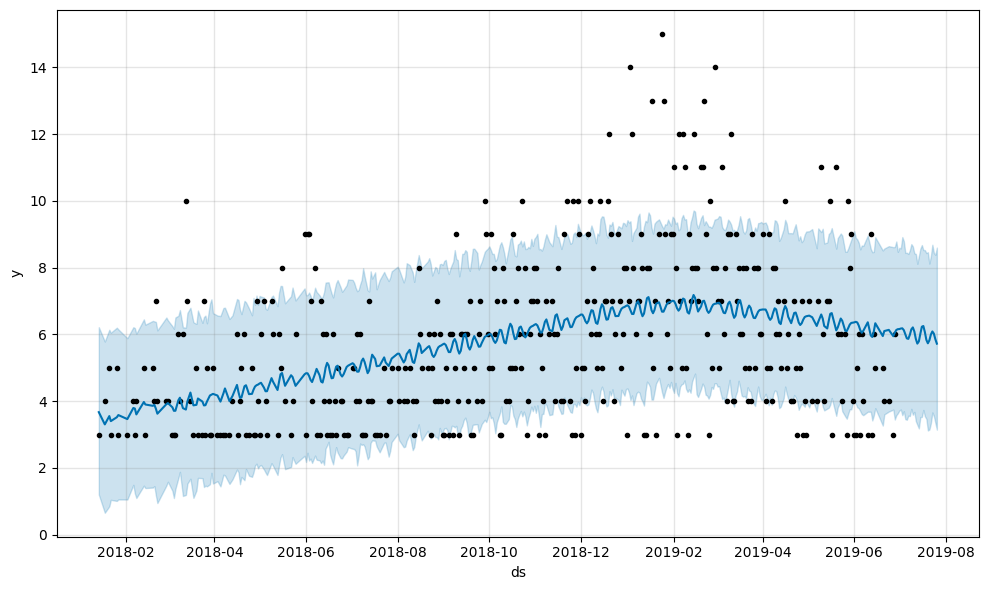

In [30]:
# Get the pickup location for the best model
sample_location_id = final_df.index[0]
print(f"sample location_id: {sample_location_id}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"type checkpoint: {type(checkpoint)}")

## OPTION 1 - Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()['forecast_df']
print(f"type restored df: {type(forecast_df)}")

# Plot the best prediction and future forecast.
temp = final_df.reset_index().copy()
print(f"location {sample_location_id}, best error {temp.loc[(temp.location_id==sample_location_id), 'error'].values[0]}")
plot1 = model.plot(forecast_df);

# # OPTION 2
# # Restore a model from checkpoint
# model = checkpoint.to_dict()['model']
# print(f"type restored model: {type(model)}")

# # Create a forecast into the future
# # Note: this is redundant work because we already did this during model training and eval
# future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
# future = model.predict(future_dates)
# print("Tail of future dates:")
# print(future_dates.tail())

# # Plot the best prediction and future forecast.
# temp = final_df.reset_index().copy()
# print(f"location {sample_location_id}, best error {temp.loc[(temp.location_id==sample_location_id), 'error'].values[0]}")
# plot1 = model.plot(future);

sample location_id: 236
type restored model: <class 'prophet.forecaster.Prophet'>
Tail of future dates:
            ds
572 2019-07-24
573 2019-07-25
574 2019-07-26
575 2019-07-27
576 2019-07-28
location 236, worst error 1286.7789830480474


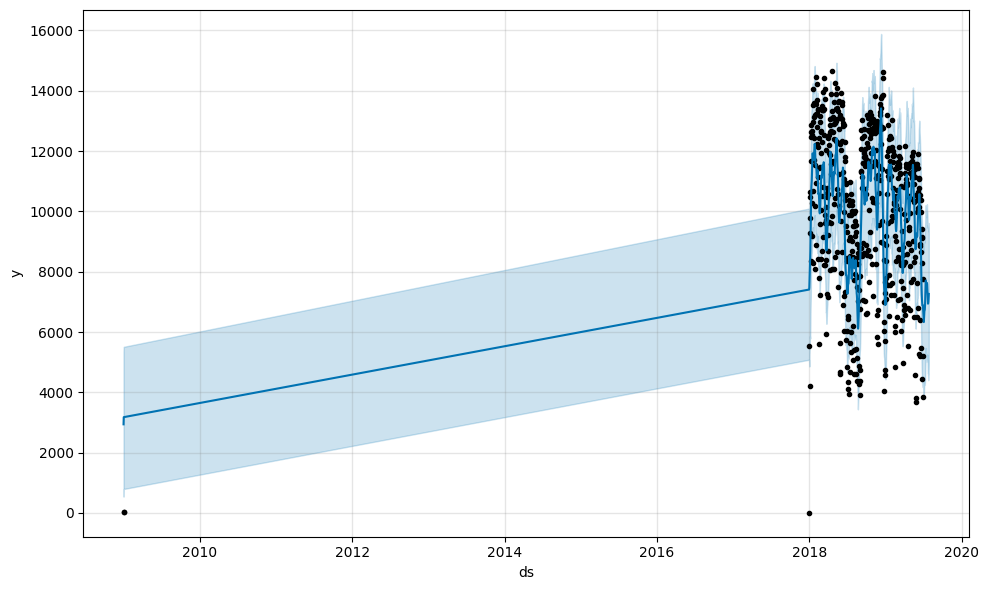

(scheduler +36m45s) Removing 9 nodes of type worker-node-type-0 (idle).
(scheduler +37m0s) Resized to 40 CPUs.


In [31]:
# Get the pickup location for the worst model
sample_location_id = final_df.index[len(final_df)-1]
print(f"sample location_id: {sample_location_id}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]

# OPTION 2
# Restore a model from checkpoint
model = checkpoint.to_dict()['model']
print(f"type restored model: {type(model)}")

# Create a forecast into the future
# Note: this is redundant work because we already did this during model training and eval
future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
future = model.predict(future_dates)
print("Tail of future dates:")
print(future_dates.tail())

# Plot the worst prediction and future forecast.
temp = final_df.reset_index().copy()
print(f"location {sample_location_id}, worst error {temp.loc[(temp.location_id==sample_location_id), 'error'].values[0]}")
plot1 = model.plot(future);

sample location_id: 183
type checkpoint: <class 'ray.air.checkpoint.Checkpoint'>
type restored model: <class 'prophet.forecaster.Prophet'>
Tail of future dates:
            ds
209 2019-07-24
210 2019-07-25
211 2019-07-26
212 2019-07-27
213 2019-07-28
location 183, error 0.2621947056837229


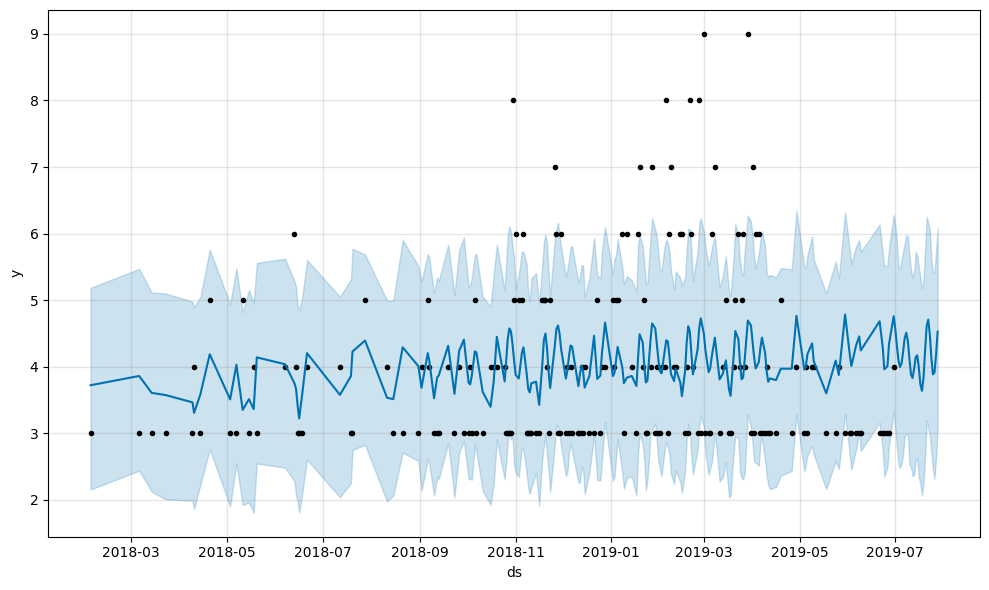

In [25]:
# Get the pickup location for an average model
sample_location_id = final_df.index[25]
print(f"sample location_id: {sample_location_id}")

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"type checkpoint: {type(checkpoint)}")

# ## OPTION 1 - Restore already-created predictions from model training and eval
# forecast_df = checkpoint.to_dict()['forecast_df']
# print(f"type restored df: {type(forecast_df)}")

# # Plot prediction and future forecast.
# temp = final_df.reset_index().copy()
# print(f"location {sample_location_id}, error {temp.loc[(temp.location_id==sample_location_id), 'error'].values[0]}")
# plot1 = model.plot(forecast_df);

# OPTION 2
# Restore a model from checkpoint
model = checkpoint.to_dict()['model']
print(f"type restored model: {type(model)}")

# Create a forecast into the future
# Note: this is redundant work because we already did this during model training and eval
future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq='D')
future = model.predict(future_dates)
print("Tail of future dates:")
print(future_dates.tail())

# Plot prediction and future forecast.
temp = final_df.reset_index().copy()
print(f"location {sample_location_id}, error {temp.loc[(temp.location_id==sample_location_id), 'error'].values[0]}")
plot1 = model.plot(future);